In [70]:
import argparse
import os

import numpy as np
import torch

import espaloma as esp


# layer
layer = esp.nn.layers.dgl_legacy.gn("SAGEConv")

# representation
representation = esp.nn.Sequential(layer, config=[128, "relu", 128, "relu", 128, "relu"])
janossy_config = [128, "relu", 128, "relu", 128, "relu", 128, "relu"]
readout = esp.nn.readout.janossy.JanossyPooling(
    in_features=128, config=janossy_config,
    out_features={
            2: {'log_coefficients': 2},
            3: {'log_coefficients': 2},
            4: {'k': 6},
    },
)

readout_improper = esp.nn.readout.janossy.JanossyPoolingImproper(
    in_features=128, config=janossy_config
)

class ExpCoeff(torch.nn.Module):
    def forward(self, g):
        import math
        g.nodes['n2'].data['coefficients'] = g.nodes['n2'].data['log_coefficients'].exp()
        g.nodes['n3'].data['coefficients'] = g.nodes['n3'].data['log_coefficients'].exp()

        g.nodes['n2'].data['k'], g.nodes['n2'].data['eq'] = esp.mm.functional.linear_mixture_to_original(
            g.nodes['n2'].data['coefficients'][:, 0][:, None],
            g.nodes['n2'].data['coefficients'][:, 1][:, None],
            1.5, 6.0,
        )

        g.nodes['n3'].data['k'], g.nodes['n3'].data['eq'] = esp.mm.functional.linear_mixture_to_original(
            g.nodes['n3'].data['coefficients'][:, 0][:, None],
            g.nodes['n3'].data['coefficients'][:, 1][:, None],
            0.0, math.pi
        )
        
        g.nodes['n2'].data.pop('coefficients')
        g.nodes['n3'].data.pop('coefficients')



        return g

class GetLoss(torch.nn.Module):
    def forward(self, g):
        return torch.nn.MSELoss()(
            g.nodes['g'].data['u'] - g.nodes['g'].data['u'].mean(dim=-1, keepdims=True),
            g.nodes['g'].data['u_ref'] - g.nodes['g'].data['u_ref'].mean(dim=-1, keepdims=True),
        )

net = torch.nn.Sequential(
        representation,
        readout,
        ExpCoeff(),
        esp.mm.geometry.GeometryInGraph(),
        esp.mm.energy.EnergyInGraph(terms=["n2", "n3"]),
        esp.mm.energy.EnergyInGraph(terms=["n2", "n3"], suffix="_ref")
)

rmse = [] 

state_dict = torch.load(
        "basic.th",
        map_location="cpu",
)

# net = net.cuda()
net.load_state_dict(state_dict)

<All keys matched successfully>

In [63]:
g = esp.Graph("[H]C1(C(OOC1(C([H])([H])[H])C([H])([H])[H])([H])[H])[H]")

esp.data.md.MoleculeVacuumSimulation(n_samples=1000).run(g)
esp.graphs.legacy_force_field.LegacyForceField().parametrize(g)

/Users/wangy1/anaconda3/envs/esp/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [71]:
net(g.heterograph)

Graph(num_nodes={'g': 1, 'n1': 17, 'n2': 34, 'n3': 64, 'n4': 86, 'n4_improper': 0, 'nonbonded': 24, 'onefour': 86},
      num_edges={('g', 'g_has_n1', 'n1'): 17, ('g', 'g_has_n2', 'n2'): 34, ('g', 'g_has_n3', 'n3'): 64, ('g', 'g_has_n4', 'n4'): 86, ('g', 'g_has_n4_improper', 'n4_improper'): 0, ('g', 'g_has_nonbonded', 'nonbonded'): 24, ('g', 'g_has_onefour', 'onefour'): 86, ('n1', 'n1_as_0_in_n2', 'n2'): 34, ('n1', 'n1_as_0_in_n3', 'n3'): 64, ('n1', 'n1_as_0_in_n4', 'n4'): 86, ('n1', 'n1_as_0_in_n4_improper', 'n4_improper'): 0, ('n1', 'n1_as_0_in_nonbonded', 'nonbonded'): 24, ('n1', 'n1_as_0_in_onefour', 'onefour'): 86, ('n1', 'n1_as_1_in_n2', 'n2'): 34, ('n1', 'n1_as_1_in_n3', 'n3'): 64, ('n1', 'n1_as_1_in_n4', 'n4'): 86, ('n1', 'n1_as_1_in_n4_improper', 'n4_improper'): 0, ('n1', 'n1_as_1_in_nonbonded', 'nonbonded'): 24, ('n1', 'n1_as_1_in_onefour', 'onefour'): 86, ('n1', 'n1_as_2_in_n3', 'n3'): 64, ('n1', 'n1_as_2_in_n4', 'n4'): 86, ('n1', 'n1_as_2_in_n4_improper', 'n4_improper'): 0,

In [72]:
from matplotlib import pyplot as plt

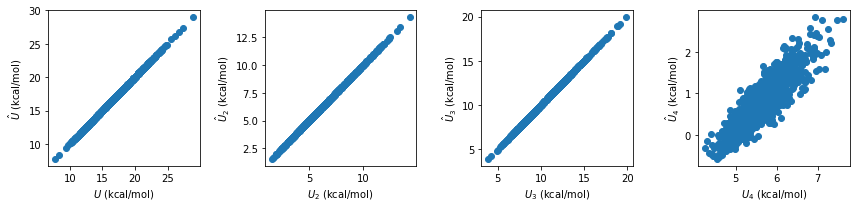

In [73]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

axs[0].scatter(
    g.nodes['g'].data['u_ref'].detach() * 625,
    g.nodes['g'].data['u'].detach() * 625
)

axs[0].set_xlabel("$U$ (kcal/mol)")
axs[0].set_ylabel("$\hat{U}$ (kcal/mol)")

axs[1].scatter(
    g.nodes['n2'].data['u_ref'].sum(dim=0).detach() * 625,
    g.nodes['n2'].data['u'].sum(dim=0).detach() * 625
)

axs[1].set_xlabel("$U_2$ (kcal/mol)")
axs[1].set_ylabel("$\hat{U}_2$ (kcal/mol)")


axs[2].scatter(
    g.nodes['n3'].data['u_ref'].sum(dim=0).detach() * 625,
    g.nodes['n3'].data['u'].sum(dim=0).detach() * 625
)

axs[2].set_xlabel("$U_3$ (kcal/mol)")
axs[2].set_ylabel("$\hat{U}_3$ (kcal/mol)")

axs[3].scatter(
    g.nodes['n4'].data['u_ref'].sum(dim=0).detach() * 625,
    g.nodes['n4'].data['u'].sum(dim=0).detach() * 625
)

axs[3].set_xlabel("$U_4$ (kcal/mol)")
axs[3].set_ylabel("$\hat{U}_4$ (kcal/mol)")


plt.tight_layout()

Text(0, 0.5, '$\\hat{b3}$ rad')

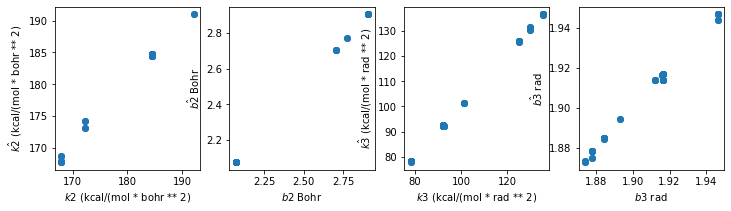

In [74]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

axs[0].scatter(
    g.nodes['n2'].data['k_ref'].detach() * 625,
    g.nodes['n2'].data['k'].detach() * 625
)

axs[0].set_xlabel("$k2$ (kcal/(mol * bohr ** 2)")
axs[0].set_ylabel("$\hat{k2}$ (kcal/(mol * bohr ** 2)")

axs[1].scatter(
    g.nodes['n2'].data['eq_ref'].detach(),
    g.nodes['n2'].data['eq'].detach()
)

axs[1].set_xlabel("$b2$ Bohr ")
axs[1].set_ylabel("$\hat{b2}$ Bohr")


axs[2].scatter(
    g.nodes['n3'].data['k_ref'].detach() * 625,
    g.nodes['n3'].data['k'].detach() * 625
)

axs[2].set_xlabel("$k3$ (kcal/(mol * rad ** 2)")
axs[2].set_ylabel("$\hat{k3}$ (kcal/(mol * rad ** 2)")

axs[3].scatter(
    g.nodes['n3'].data['eq_ref'].detach(),
    g.nodes['n3'].data['eq'].detach()
)

axs[3].set_xlabel("$b3$ rad ")
axs[3].set_ylabel("$\hat{b3}$ rad")


In [41]:
(g.nodes['n3'].data['k'] * (g.nodes['n3'].data['x'] - g.nodes['n3'].data['eq']) ** 2).sum(dim=-1)

tensor([1.0683, 1.0645, 0.9998, 0.9597, 1.0507, 1.0486, 1.0683, 1.0645, 0.9998,
        0.9597, 1.0507, 1.0486], grad_fn=<SumBackward1>)